* Jorge Galvis Carrillo, uni: jag2425
* Maci Sekander, uni: ms7278

## Performace Attribution Analysis

#### This project applies the Capital Asset Pricing Model (CAPM) to decompose portfolio performance into alpha and beta components, allowing us to quantify the proportion of returns driven by market risk versus manager skill. Using regression analysis on historical returns for U.S. equity portfolios and market factors, we estimate and test the significance of alpha across sectors. This analysis mirrors performance attribution frameworks used in hedge funds and asset management firms, linking theoretical regression concepts to real-world application. 


---

## STEP 1: Portfolio Selection

Objective: Select equity ETFs or funds for analysis

ETFs to analyze:
- XLK (Technology Sector)
- XLF (Financials Sector)
- XLU (Utilities Sector)
- SPY (S&P 500 Market Benchmark)

Analysis period: 2018-2024

In [1]:
%pip install pandas numpy matplotlib yfinance seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf   
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

In [3]:
# Define portfolio tickers and analysis period
tickers = ["XLK", "XLF", "XLU", "SPY"]
start_date = '2018-01-01'
end_date = '2025-01-01'

---

## STEP 2: Data Collection

Objective: Collect necessary data for each time period (weekly or monthly)

Required data for each period:
1. Portfolio/Fund Returns: Historical price data for XLK, XLF, XLU, SPY
2. Market Return: SPY or MKT-RF from Fama-French dataset
3. Risk-Free Rate: T-bill yield from Fama-French dataset

Data sources:
- Yahoo Finance (ETF prices)
- Kenneth French Data Library (Fama-French factors)

In [4]:
# Download ETF price data from Yahoo Finance

# Data will include Open, High, Low, Close, Adjusted Close, and Volume
tickers = ["XLK", "XLF", "XLU", "SPY"]
data = yf.download(tickers, start=start_date, end=end_date, interval="1mo", auto_adjust=False)
data.head()

[*********************100%***********************]  4 of 4 completed


Price        Adj Close                                        Close  \
Ticker             SPY        XLF        XLK        XLU         SPY   
Date                                                                  
2018-01-01  249.531570  25.661209  31.672062  19.975155  281.899994   
2018-02-01  240.458496  24.910524  31.542511  19.200258  271.649994   
2018-03-01  232.934402  23.788820  30.270069  19.775558  263.149994   
2018-04-01  235.076050  23.771502  30.383339  20.335434  264.510010   
2018-05-01  240.790497  23.537680  32.444168  20.110622  270.940002   

Price                                              High             ...  \
Ticker            XLF        XLK        XLU         SPY        XLF  ...   
Date                                                                ...   
2018-01-01  29.740000  34.224998  25.520000  286.630005  30.330000  ...   
2018-02-01  28.870001  34.084999  24.530001  283.059998  30.049999  ...   
2018-03-01  27.570000  32.709999  25.264999  280.410004  29.809999  ...   
2018-04-01  27.450001  32.730000  25.780001  271.299988  28.240000  ...   
2018-05-01  27.180000  34.950001  25.495001  274.250000  28.500000  ...   

Price             Low                   Open                                   \
Ticker            XLK        XLU         SPY        XLF        XLK        XLU   
Date                                                                            
2018-01-01  32.025002  24.930000  267.839996  28.090000  32.105000  26.334999   
2018-02-01  30.485001  23.684999  281.070007  29.680000  34.099998  25.490000   
2018-03-01  31.885000  24.264999  271.410004  28.879999  34.165001  24.580000   
2018-04-01  31.575001  24.650000  262.549988  27.570000  32.580002  25.309999   
2018-05-01  32.605000  24.305000  263.869995  27.389999  32.685001  25.780001   

Price           Volume                                    
Ticker             SPY         XLF        XLK        XLU  
Date                                                      
2018-01-01  1985506700  1102927300  534609200  836384400  
2018-02-01  2923722000  1511800000  755941400  896112000  
2018-03-01  2323561800  1304468400  678801600  768334400  
2018-04-01  1998466500  1239654600  619898200  577627200  
2018-05-01  1606397200  1062360700  541204000  582083200  

[5 rows x 24 columns]

In [5]:
# Download Fama-French factors (market return and risk-free rate)
ff_factors = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=3)
ff_factors = ff_factors.rename(columns={ff_factors.columns[0]: "Date"})

# keep only monthly rows like 192607, 202512, etc.
ff_factors = ff_factors[ff_factors["Date"].astype(str).str.fullmatch(r"\d{6}")]

ff_factors["Date"] = pd.to_datetime(ff_factors["Date"], format="%Y%m")
ff_factors = ff_factors.set_index("Date").apply(pd.to_numeric, errors="coerce") # Convert all columns to numeric and nan for non-numeric
ff_factors.head()


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,2.89,-2.55,-2.39,0.22
1926-08-01,2.64,-1.14,3.81,0.25
1926-09-01,0.38,-1.36,0.05,0.23
1926-10-01,-3.27,-0.14,0.82,0.32
1926-11-01,2.54,-0.11,-0.61,0.31


---

## STEP 3: Data Preparation

Objective: Transform raw data into analysis-ready format

Tasks:
1. Convert prices to returns: $R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$
2. Align all series by date
3. Compute excess returns:
   - Portfolio excess return: $r_i = R_i - R_f$
   - Market excess return: $r_m = R_M - R_f$

Output: Clean DataFrame with aligned dates and excess returns for all portfolios and market

In [6]:
# Calculate monthly returns from Adjusted Close prices

# Using Adjusted Close ensures dividends/splits are incorporated
prices = data['Adj Close'].dropna(how='all')
returns = prices.pct_change().dropna()
returns.head()

Ticker,SPY,XLF,XLK,XLU
Date,,,,
2018-02-01,-0.036360,-0.029254,-0.004090,-0.038793
2018-03-01,-0.031291,-0.045029,-0.040341,0.029963
2018-04-01,0.009194,-0.000728,0.003742,0.028311
2018-05-01,0.024309,-0.009836,0.067828,-0.011055
2018-06-01,0.001255,-0.021707,-0.006152,0.019023


In [7]:
# Align data by date and handle missing values

# RF is in percentage => convert to decimal
rf = (ff_factors['RF'] / 100.0)
aligned = returns.join(rf, how='inner').dropna()
aligned.head()

,SPY,XLF,XLK,XLU,RF
Date,,,,,
2018-02-01,-0.036360,-0.029254,-0.004090,-0.038793,0.0011
2018-03-01,-0.031291,-0.045029,-0.040341,0.029963,0.0012
2018-04-01,0.009194,-0.000728,0.003742,0.028311,0.0014
2018-05-01,0.024309,-0.009836,0.067828,-0.011055,0.0014
2018-06-01,0.001255,-0.021707,-0.006152,0.019023,0.0014


In [8]:
# Compute excess returns

# Market factor (SPY approximation) - called the premium of the market over risk-free rate
aligned['Mkt_RF_SPY'] = aligned['SPY'] - aligned['RF']

# Excess returns of each asset 
excess = aligned[['XLF','XLK','XLU']].sub(aligned['RF'], axis=0)

---

## STEP 4: Exploratory Data Analysis

Objective: Understand the data through descriptive statistics and visualizations

### 4.1 Descriptive Statistics
- Mean: which ETF perform better on average, and also suggest alpha when ETF mean > market mean
- Standard Deviation: which ETF was the most volatile, and the higher volatility, the higher the beta 
- Min, Max: sector specific shocks and persistance compared to market benchmark
- Correlation matrix: beta exposure based on the market, high correlation $\implies$ ETF moves closely with the market

### 4.2 Visualizations
1. Time series plots of returns for each ETF: to visualize how closely the ETFs move with the market
2. Scatterplots of $r_i$ vs $r_m$ for each portfolio: If the point is above 0, that ETF outperformed the risk-free rate that month. If it’s below 0, the ETF underperformed. If it’s to the right, the market was up; to the left, the market was down.
3. Correlation heatmap: to visualize the temperature of the correlation 
4. Distribution plots (histograms or density plots): x-axis shows monthly excess return values (mostly concentrated +- 5%) and y-axis shows the count (frequency) of months where the ETF had a return in that range.

In [9]:
# Descriptive statistics

# Simple yearly mean of monthly excess returns 
mean_excess_yearly = excess.groupby(excess.index.year).mean()
mean_market_yearly = aligned.groupby(aligned.index.year)['Mkt_RF_SPY'].mean()

# Geometric compounding of monthly returns inside each year
annualized_excess = (1 + excess).groupby(excess.index.year).prod() - 1
annualized_market = (1 + aligned['Mkt_RF_SPY']).groupby(aligned.index.year).prod() - 1

# Combine into a summary DataFrame
summary_yearly = pd.concat([
    mean_excess_yearly.add_suffix('_mean_monthly'),
    annualized_excess.add_suffix('_annualized'),
    mean_market_yearly.to_frame(name='Mkt_RF_SPY_mean_monthly'),
    annualized_market.to_frame(name='Mkt_RF_SPY_annualized')
], axis=1)

# Rough naive alpha signal per year (difference between ETF annualized excess and market annualized excess)
# A heuristic for CAPM
alpha_naive = annualized_excess.sub(annualized_market, axis=0).add_suffix('_alpha_naive')
summary_yearly = summary_yearly.join(alpha_naive)

summary_yearly

,XLF_mean_monthly,XLK_mean_monthly,XLU_mean_monthly,XLF_annualized,XLK_annualized,XLU_annualized,Mkt_RF_SPY_mean_monthly,Mkt_RF_SPY_annualized,XLF_alpha_naive,XLK_alpha_naive,XLU_alpha_naive
Date,,,,,,,,,,,
2018,-0.019453,-0.008471,0.004503,-0.202888,-0.100823,0.046077,-0.010395,-0.117011,-0.085876,0.016188,0.163089
2019,0.022889,0.033649,0.017898,0.293120,0.469643,0.234226,0.021869,0.286455,0.006664,0.183188,-0.052229
2020,0.002912,0.033241,0.001942,-0.022521,0.430887,-0.000223,0.016487,0.178470,-0.200992,0.252416,-0.178693
2021,0.026444,0.025869,0.015129,0.348616,0.347898,0.177622,0.021813,0.288126,0.060490,0.059772,-0.110504
2022,-0.008100,-0.024749,0.001702,-0.119588,-0.288248,-0.000027,-0.015702,-0.194132,0.074544,-0.094116,0.194105
2023,0.007299,0.035283,-0.009408,0.069252,0.489860,-0.116963,0.016403,0.203840,-0.134588,0.286020,-0.320803
2024,0.019194,0.012969,0.014811,0.242388,0.156892,0.173730,0.014889,0.188201,0.054187,-0.031309,-0.014471


In [10]:
# Monthly vol per year (what you already had)
std_excess_m = excess.groupby(excess.index.year).std(ddof=1)
std_mkt_m    = aligned.groupby(aligned.index.year)['Mkt_RF_SPY'].std(ddof=1)

# Annualized vol from monthly data (√12)
std_excess_ann = std_excess_m * np.sqrt(12)
std_mkt_ann    = std_mkt_m    * np.sqrt(12)

# Combine nicely
std_summary_yearly = pd.concat(
    [
        std_excess_m.add_suffix('_std_monthly'),
        std_mkt_m.to_frame(name='Mkt_RF_SPY_std_monthly'),
        std_excess_ann.add_suffix('_std_annual'),
        std_mkt_ann.to_frame(name='Mkt_RF_SPY_std_annual'),
    ],
    axis=1
)

std_summary_yearly

,XLF_std_monthly,XLK_std_monthly,XLU_std_monthly,Mkt_RF_SPY_std_monthly,XLF_std_annual,XLK_std_annual,XLU_std_annual,Mkt_RF_SPY_std_annual
Date,,,,,,,,
2018,0.044843,0.049839,0.029493,0.042657,0.155339,0.172648,0.102165,0.147769
2019,0.052087,0.047354,0.021368,0.037884,0.180433,0.164040,0.074020,0.131235
2020,0.099861,0.080504,0.064739,0.076643,0.345928,0.278873,0.224263,0.265499
2021,0.051936,0.038601,0.055807,0.032826,0.179911,0.133717,0.193323,0.113712
2022,0.073146,0.083566,0.060564,0.068071,0.253387,0.289481,0.209800,0.235806
2023,0.060969,0.058078,0.043975,0.042692,0.211202,0.201189,0.152333,0.147888
2024,0.045622,0.040597,0.054453,0.030149,0.158038,0.140631,0.188630,0.104438


In [11]:
# Min and Max of monthly excess returns
min_excess_yearly = excess.groupby(excess.index.year).min()
max_excess_yearly = excess.groupby(excess.index.year).max()
min_market_yearly = aligned.groupby(aligned.index.year)['Mkt_RF_SPY'].min()
max_market_yearly = aligned.groupby(aligned.index.year)['Mkt_RF_SPY'].max()
min_summary_yearly = pd.concat([
    min_excess_yearly.add_suffix('_min_monthly'),
    min_market_yearly.to_frame(name='Mkt_RF_SPY_min_monthly')
], axis=1)  
max_summary_yearly = pd.concat([
    max_excess_yearly.add_suffix('_max_monthly'),
    max_market_yearly.to_frame(name='Mkt_RF_SPY_max_monthly')
], axis=1)
min_max_summary_yearly = min_summary_yearly.join(max_summary_yearly)
min_max_summary_yearly

,XLF_min_monthly,XLK_min_monthly,XLU_min_monthly,Mkt_RF_SPY_min_monthly,XLF_max_monthly,XLK_max_monthly,XLU_max_monthly,Mkt_RF_SPY_max_monthly
Date,,,,,,,,
2018,-0.118696,-0.089624,-0.049930,-0.095243,0.054100,0.066428,0.033588,0.040103
2019,-0.073834,-0.088747,-0.019877,-0.065871,0.093691,0.083747,0.049282,0.084272
2020,-0.218199,-0.091728,-0.110078,-0.131187,0.168382,0.143304,0.086873,0.133611
2021,-0.057128,-0.060053,-0.067989,-0.049650,0.116062,0.083674,0.097327,0.073592
2022,-0.113935,-0.123740,-0.120678,-0.098059,0.122824,0.136667,0.096128,0.096005
2023,-0.103544,-0.071077,-0.068309,-0.055083,0.104994,0.124556,0.047032,0.086944
2024,-0.062329,-0.060761,-0.091002,-0.042038,0.100561,0.072366,0.085201,0.055633


In [12]:
# Correlation matrix  
corr_data = excess.copy()
corr_data['Mkt_RF_SPY'] = aligned['Mkt_RF_SPY']
corr_matrix = corr_data.corr()
corr_matrix


,XLF,XLK,XLU,Mkt_RF_SPY
XLF,1.000000,0.657315,0.506723,0.862928
XLK,0.657315,1.000000,0.406065,0.914500
XLU,0.506723,0.406065,1.000000,0.583346
Mkt_RF_SPY,0.862928,0.914500,0.583346,1.000000


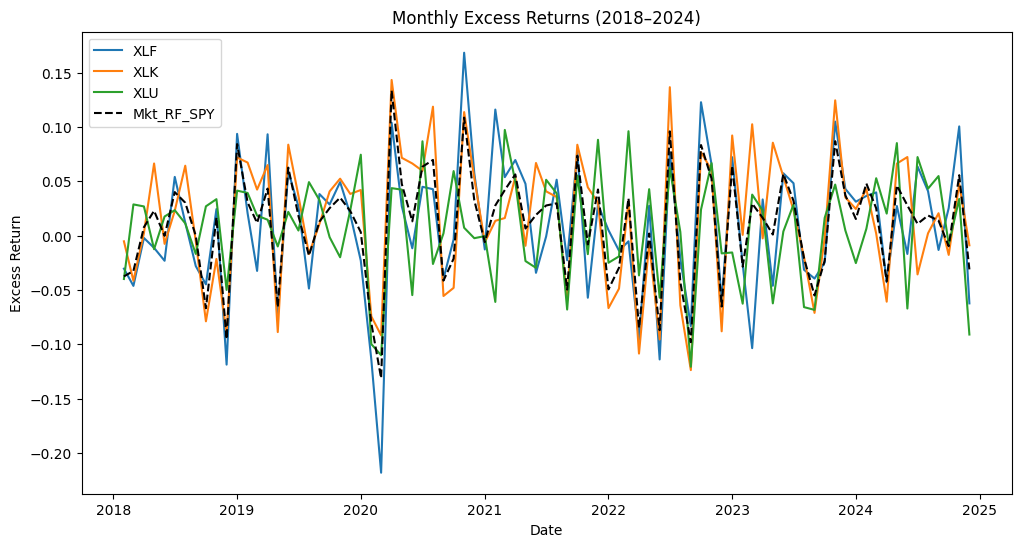

In [13]:
# Time series plots
plt.figure(figsize=(12, 6))
for etf in excess.columns:
    plt.plot(excess.index, excess[etf], label=etf)
plt.plot(aligned.index, aligned['Mkt_RF_SPY'], label='Mkt_RF_SPY', linestyle='--', color='black')
plt.title('Monthly Excess Returns (2018–2024)')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.legend()
plt.show()


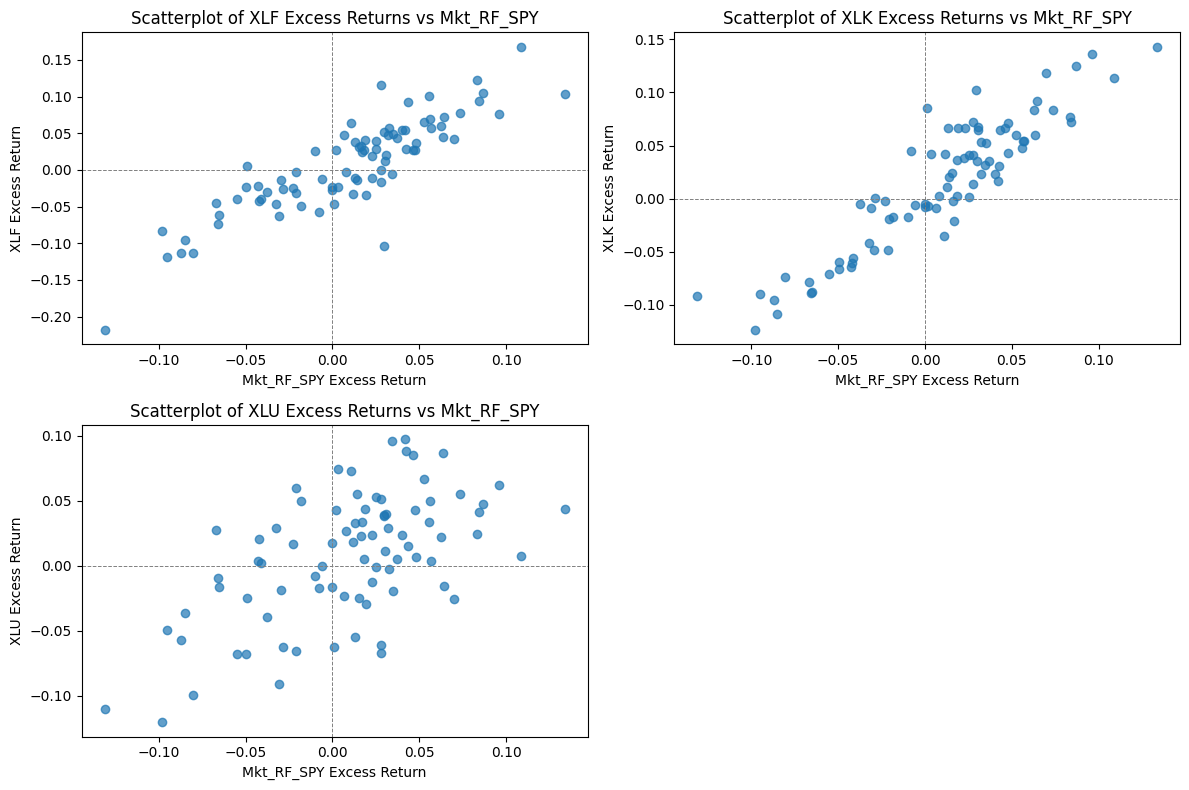

In [14]:
# Scatterplots 
plt.figure(figsize=(12, 8))
for i, etf in enumerate(excess.columns, 1):
    plt.subplot(2, 2, i)
    plt.scatter(aligned['Mkt_RF_SPY'], excess[etf], alpha=0.7)
    plt.title(f'Scatterplot of {etf} Excess Returns vs Mkt_RF_SPY')
    plt.xlabel('Mkt_RF_SPY Excess Return')
    plt.ylabel(f'{etf} Excess Return')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()  


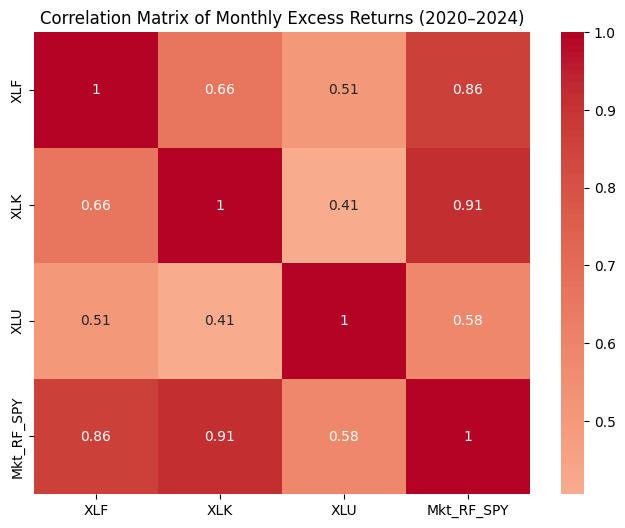

In [15]:
# Correlation heatmap between ETFs and Market 
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Monthly Excess Returns (2020–2024)")
plt.show()

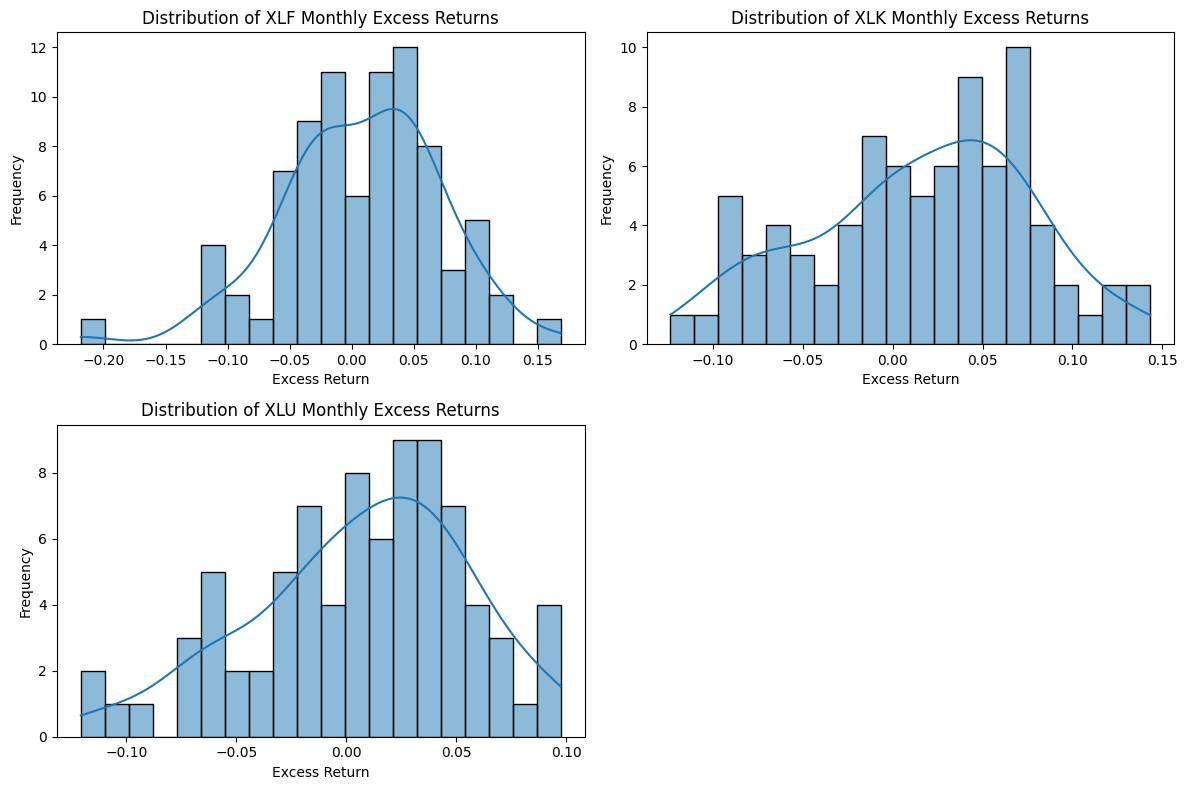

In [16]:
# Distribution plots (histograms or density plots)
plt.figure(figsize=(12, 8))
for i, etf in enumerate(excess.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(excess[etf], kde=True, bins=20)
    plt.title(f'Distribution of {etf} Monthly Excess Returns')
    plt.xlabel('Excess Return')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

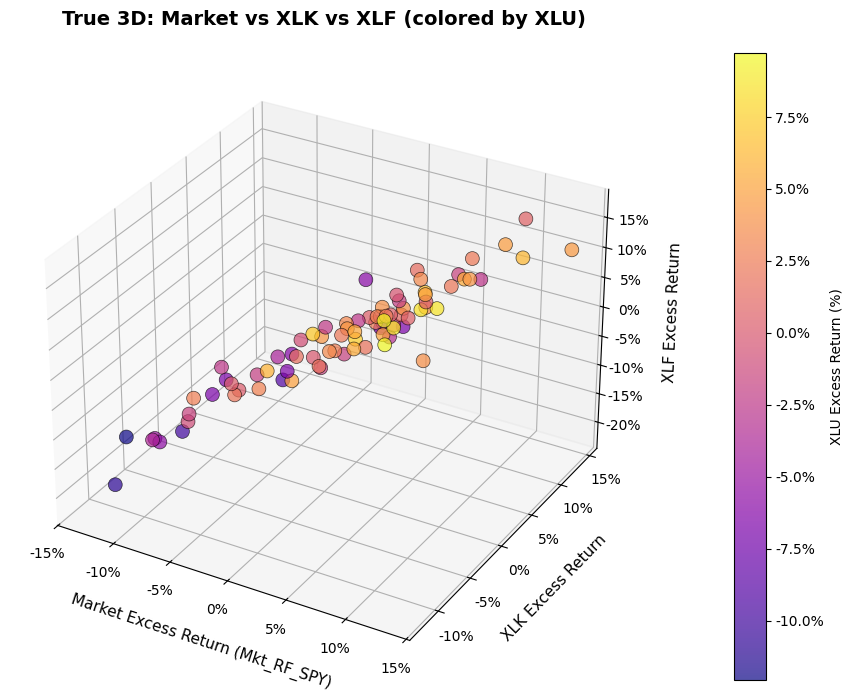

In [17]:
# True 3D Interactive Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot
scatter_3d = ax.scatter(aligned['Mkt_RF_SPY'], excess['XLK'], excess['XLF'],
                       c=excess['XLU'], s=100, cmap='plasma', alpha=0.7,
                       edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter_3d, ax=ax, label='XLU Excess Return (%)', pad=0.1)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))

# Labels and title
ax.set_xlabel('Market Excess Return (Mkt_RF_SPY)', fontsize=11, labelpad=10)
ax.set_ylabel('XLK Excess Return', fontsize=11, labelpad=10)
ax.set_zlabel('XLF Excess Return', fontsize=11, labelpad=10)
ax.set_title('True 3D: Market vs XLK vs XLF (colored by XLU)', fontsize=14, fontweight='bold', pad=20)

# Format tick labels as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.0f}%'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.0f}%'))
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.0f}%'))

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## STEP 5: CAPM Regression Analysis

Objective: Estimate alpha and beta for each portfolio

### The CAPM Regression Model:
$$r_i = \alpha + \beta \cdot r_m + \varepsilon$$

Where:
- $r_i$ = Portfolio excess return
- $r_m$ = Market excess return
- $\alpha$ = Jensen's alpha (risk-adjusted performance)
- $\beta$ = Systematic risk (market sensitivity)
- $\varepsilon$ = Error term

For each ETF, estimate and record:
1. Alpha (intercept)
2. Beta (slope coefficient)
3. t-statistics
4. p-values
5. $R^2$ (model fit)

Interpretation:
- Beta approximately 1: Moves with the market
- Beta greater than 1: Aggressive/volatile sector
- Beta less than 1: Defensive sector
- Significant positive alpha: Outperformance
- Significant negative alpha: Underperformance

In [18]:
# Prepare inputs using previously computed series
etf_excess = excess.copy()
market_excess = aligned['Mkt_RF_SPY']
capm_data = etf_excess.join(market_excess.rename('Mkt_RF'), how='inner').dropna()

# Run OLS regression for each ETF
X = capm_data[['Mkt_RF']].values
results = []
for col in etf_excess.columns:
    y = capm_data[col].values
    if len(y) < 3:
        continue
    model = LinearRegression().fit(X, y)
    beta = float(model.coef_[0])
    alpha = float(model.intercept_)
    y_pred = model.predict(X)
    resid = y - y_pred
    n = len(y)
    sse = float(np.dot(resid, resid))
    sigma2 = sse / (n - 2)
    x = capm_data['Mkt_RF'].values
    x_mean = x.mean()
    sxx = float(np.dot(x - x_mean, x - x_mean))
    se_beta = np.sqrt(sigma2 / sxx) if sxx > 0 else np.nan
    se_alpha = np.sqrt(sigma2 * (1.0/n + x_mean**2 / sxx)) if sxx > 0 else np.nan
    t_beta = beta / se_beta if se_beta and not np.isnan(se_beta) else np.nan
    t_alpha = alpha / se_alpha if se_alpha and not np.isnan(se_alpha) else np.nan
    p_beta = 2 * (1 - stats.t.cdf(np.abs(t_beta), df=n-2)) if not np.isnan(t_beta) else np.nan
    p_alpha = 2 * (1 - stats.t.cdf(np.abs(t_alpha), df=n-2)) if not np.isnan(t_alpha) else np.nan
    ss_tot = float(np.dot(y - y.mean(), y - y.mean()))
    r2 = 1 - sse/ss_tot if ss_tot > 0 else np.nan
    results.append({
        'ETF': col,
        'alpha': alpha,
        'beta': beta,
        't_alpha': t_alpha,
        'p_alpha': p_alpha,
        't_beta': t_beta,
        'p_beta': p_beta,
        'R2': r2
    })

In [19]:
# Create summary table of regression results
capm_summary = pd.DataFrame(results).set_index('ETF').sort_index()
capm_summary

,alpha,beta,t_alpha,p_alpha,t_beta,p_beta,R2
ETF,,,,,,,
XLF,-0.002788,1.088477,-0.771352,0.442743,15.368973,0.000000e+00,0.744645
XLK,0.005032,1.112625,1.802636,0.075165,20.342973,0.000000e+00,0.836310
XLU,0.001276,0.564296,0.286431,0.775280,6.463882,7.153674e-09,0.340293


---

## STEP 6: Model Diagnostics

Objective: Validate regression assumptions and check model quality

### Diagnostic Checks:

#### 6.1 Residual Analysis
- Residuals vs. Fitted Values (check for heteroscedasticity and patterns)
- Residual plots should show random scatter around zero

#### 6.2 Normality Tests
- Q-Q Plot (check if residuals are normally distributed)
- Shapiro-Wilk test (optional)

#### 6.3 Influential Points
- Cook's Distance (identify outliers and influential observations)
- Leverage plots (detect high-leverage points)

#### 6.4 Advanced Analysis (Optional)
- Rolling Regression (test if beta changes over time)
- Stability tests (check for structural breaks)

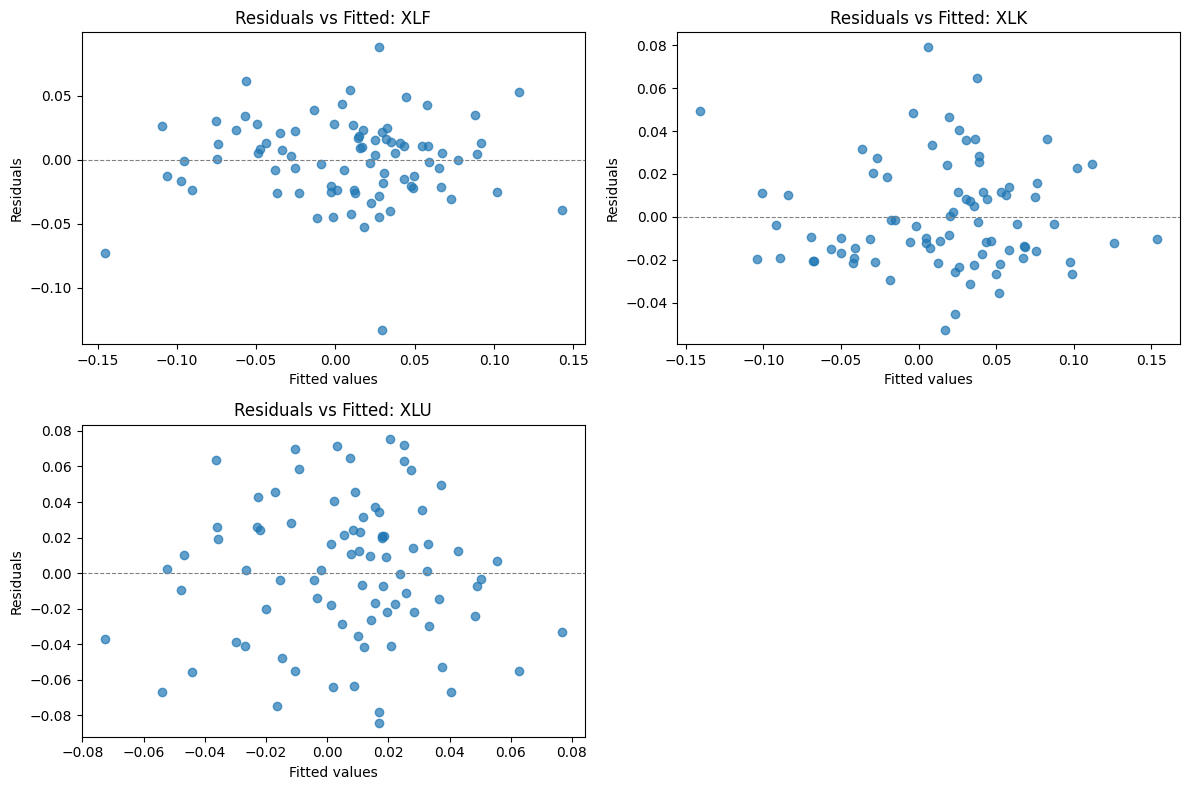

In [20]:
# Residual analysis

# Build residuals per ETF using previously fitted X and capm_data
residuals = {}
fitted = {}
for col in capm_data.columns.drop('Mkt_RF'):
    y = capm_data[col].values
    X = capm_data[['Mkt_RF']].values
    # Refit quickly to get predictions (keeps consistent with Step 5)
    model = LinearRegression().fit(X, y)
    y_hat = model.predict(X)
    residuals[col] = y - y_hat
    fitted[col] = y_hat

# Plot residuals vs fitted for each ETF
plt.figure(figsize=(12, 8))
for i, col in enumerate(residuals.keys(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(fitted[col], residuals[col], alpha=0.7)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.title(f'Residuals vs Fitted: {col}')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

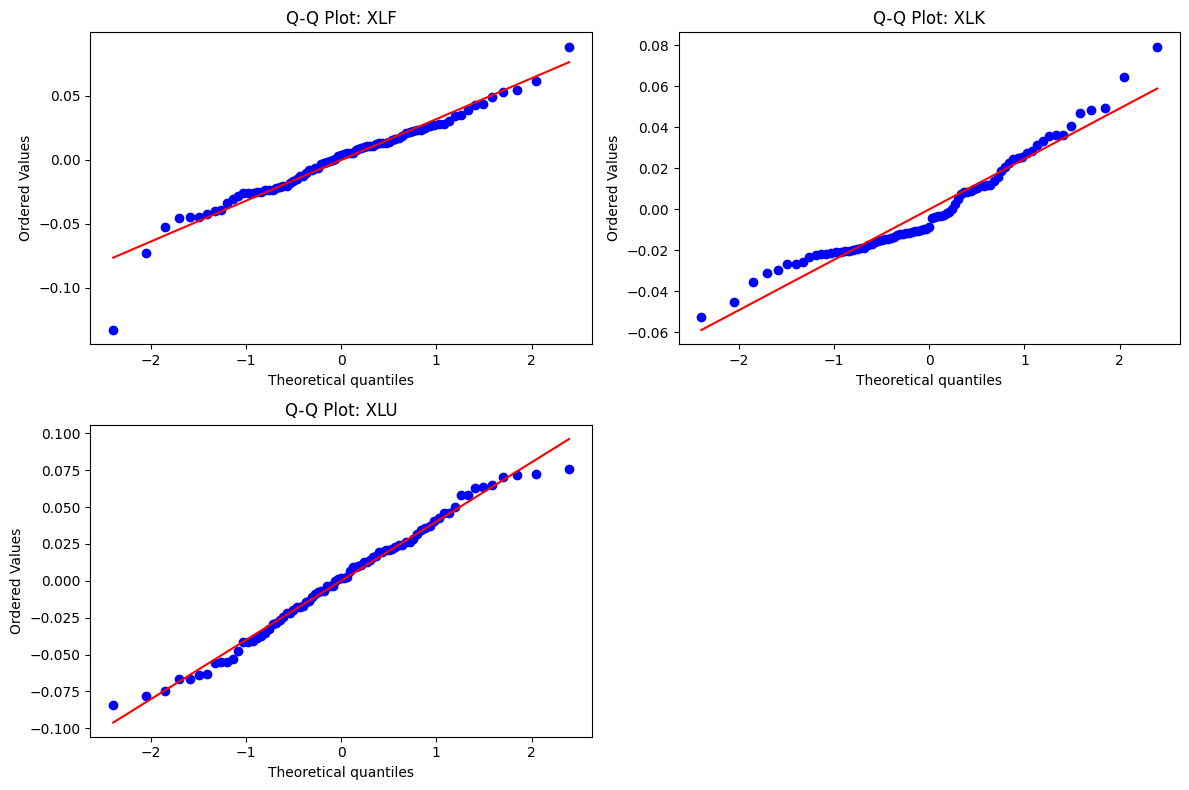

,shapiro_stat,shapiro_pvalue
XLF,0.961337,0.013574
XLK,0.950305,0.002886
XLU,0.983237,0.354017


In [21]:
# Normality tests and Q-Q plots

# Use residuals computed above
plt.figure(figsize=(12, 8))
for i, col in enumerate(residuals.keys(), 1):
    plt.subplot(2, 2, i)
    stats.probplot(residuals[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {col}')
plt.tight_layout()
plt.show()

# Shapiro-Wilk p-values for normality (small samples ok)
normality = {}
for col in residuals.keys():
    # Guard against constant residuals
    if np.allclose(np.std(residuals[col]), 0):
        normality[col] = {'stat': np.nan, 'pvalue': np.nan}
        continue
    stat, p = stats.shapiro(residuals[col])
    normality[col] = {'stat': float(stat), 'pvalue': float(p)}

pd.DataFrame(normality).T.rename(columns={'stat':'shapiro_stat','pvalue':'shapiro_pvalue'})

In [22]:
# Influential points analysis

# Simple Cook's distance approximation for simple linear regression
influence = {}
x = capm_data['Mkt_RF'].values
X = np.column_stack([np.ones_like(x), x])
# Hat matrix diagonal h_ii = x_i^T (X^T X)^{-1} x_i
XtX_inv = np.linalg.inv(X.T @ X)
h = np.array([X[i,:] @ XtX_inv @ X[i,:].T for i in range(len(x))])

for col in capm_data.columns.drop('Mkt_RF'):
    y = capm_data[col].values
    # Refit to get residuals and MSE
    model = LinearRegression().fit(x.reshape(-1,1), y)
    y_hat = model.predict(x.reshape(-1,1))
    resid = y - y_hat
    n = len(y)
    p = 2  # intercept + slope
    mse = np.sum(resid**2) / (n - p)
    # Cook's distance: D_i = (resid_i^2 / (p * mse)) * (h_i / (1 - h_i)^2)
    D = (resid**2 / (p * mse)) * (h / (1 - h)**2)
    influence[col] = pd.DataFrame({
        'CookD': D,
        'Leverage_h': h,
        'Residual': resid
    }, index=capm_data.index)

# Display top 5 most influential points per ETF
tops = {col: df.sort_values('CookD', ascending=False).head(5) for col, df in influence.items()}
for col, df in tops.items():
    display(df)

,CookD,Leverage_h,Residual
Date,,,
2020-03-01,0.338226,0.107032,-0.072617
2023-03-01,0.121170,0.013958,-0.132904
2020-11-01,0.089244,0.059128,0.052878
2020-04-01,0.073627,0.085798,-0.038741
2022-01-01,0.055258,0.028729,0.061622


,CookD,Leverage_h,Residual
Date,,,
2020-03-01,0.260361,0.107032,0.049202
2023-05-01,0.064235,0.012399,0.079411
2023-03-01,0.048070,0.013958,0.064645
2020-08-01,0.032612,0.029375,0.036130
2024-07-01,0.027569,0.012056,-0.052777


,CookD,Leverage_h,Residual
Date,,,
2022-09-01,0.108508,0.067584,-0.066621
2020-11-01,0.064304,0.059128,-0.055328
2020-03-01,0.058812,0.107032,-0.037325
2020-02-01,0.055057,0.050827,-0.055705
2018-10-01,0.054934,0.040004,0.063435


---

## STEP 7: Final Visualizations

Objective: Produce publication-quality figures for the report (minimum 4 graphs)

### Required Visualizations:

#### 7.1 Scatterplot with Regression Line
Plot $r_i$ vs $r_m$ for each ETF with fitted regression line displaying alpha and beta values

#### 7.2 Residual Diagnostic Plot
Residuals vs fitted values to check for patterns and heteroscedasticity

#### 7.3 Time Series Analysis
Cumulative excess returns over time


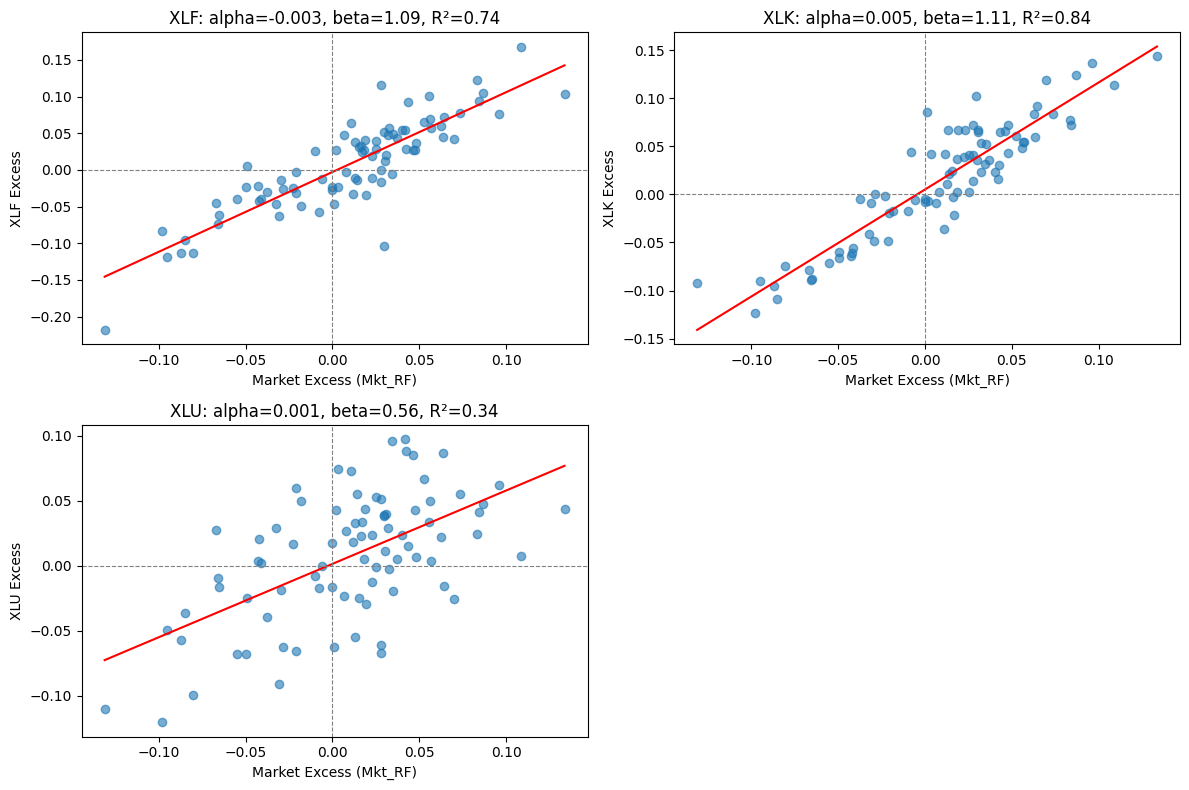

In [23]:
# Scatterplot with regression line and annotations

plt.figure(figsize=(12, 8))
for i, etf in enumerate(etf_excess.columns, 1):
    plt.subplot(2, 2, i)
    x = capm_data['Mkt_RF'].values
    y = capm_data[etf].values
    # Fit line
    from sklearn.linear_model import LinearRegression
    m = LinearRegression().fit(x.reshape(-1,1), y)
    y_hat = m.predict(x.reshape(-1,1))
    beta = float(m.coef_[0])
    alpha = float(m.intercept_)
    r2 = 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)
    # Scatter and line
    plt.scatter(x, y, alpha=0.6)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, alpha + beta*xs, color='red', linewidth=1.5)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.title(f'{etf}: alpha={alpha:.3f}, beta={beta:.2f}, R²={r2:.2f}')
    plt.xlabel('Market Excess (Mkt_RF)')
    plt.ylabel(f'{etf} Excess')
plt.tight_layout()
plt.show()

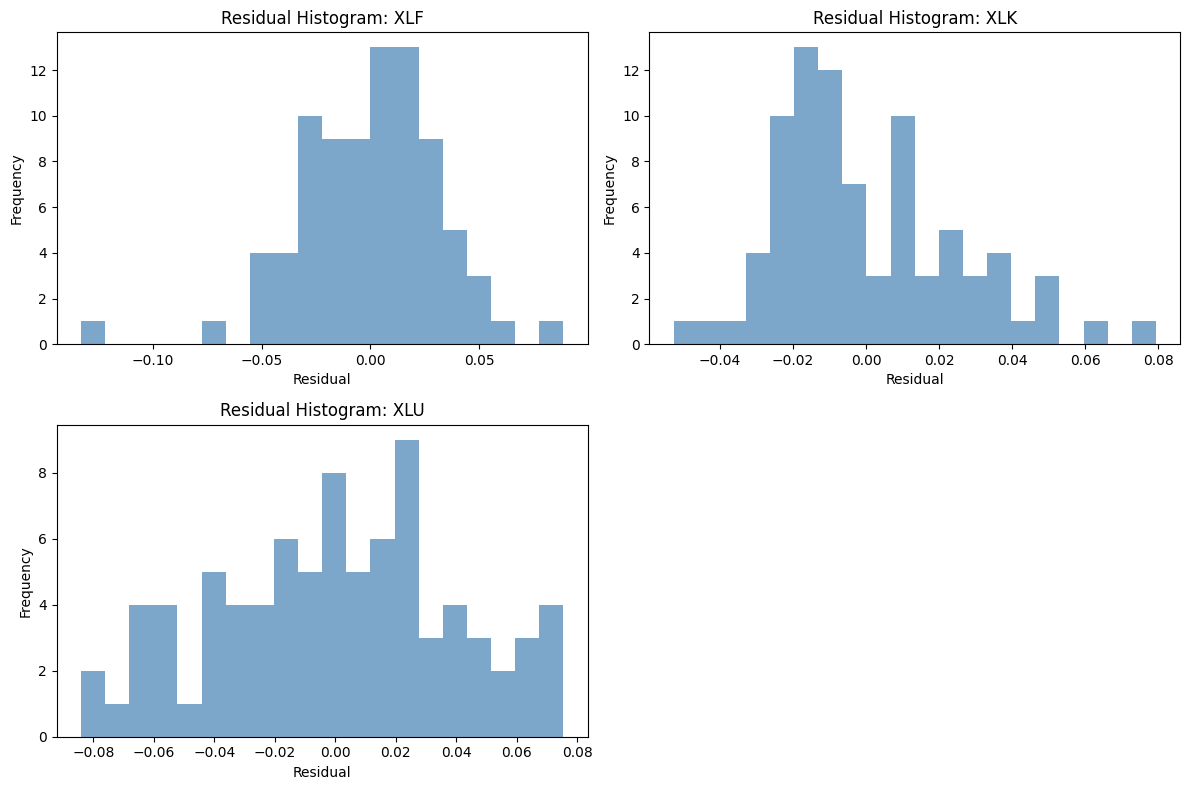

In [24]:
# Residual diagnostic plots (complementary) sort of show normality

plt.figure(figsize=(12, 8))
for i, etf in enumerate(residuals.keys(), 1):
    plt.subplot(2, 2, i)
    plt.hist(residuals[etf], bins=20, alpha=0.7, color='steelblue')
    plt.title(f'Residual Histogram: {etf}')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

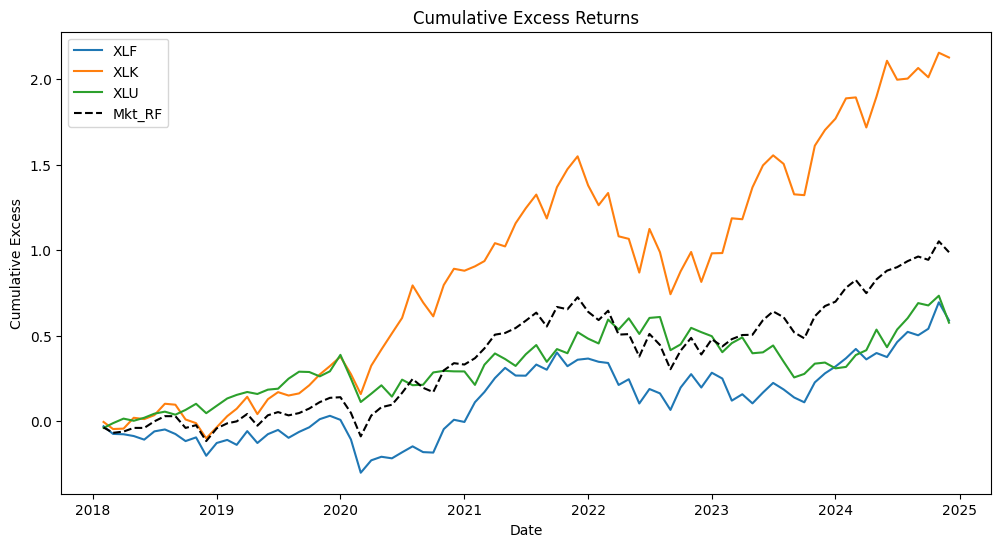

In [25]:
# Time series analysis: cumulative excess and rolling alpha

# Cumulative excess returns
cum_excess = (1 + etf_excess).cumprod() - 1
cum_market = (1 + capm_data['Mkt_RF']).cumprod() - 1

plt.figure(figsize=(12, 6))
for etf in etf_excess.columns:
    plt.plot(cum_excess.index, cum_excess[etf], label=etf)
plt.plot(cum_market.index, cum_market, label='Mkt_RF', linestyle='--', color='black')
plt.title('Cumulative Excess Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Excess')
plt.legend()
plt.show()